# Calibration - broken

Kevin Walchko

---

I made some changes and it broke!!!

We can use `apriltags` to calibrate a camera. 

`cv2.aruco` can detect these tags:

```python
cv2.aruco.DICT_APRILTAG_16H5 = 17
cv2.aruco.DICT_APRILTAG_25h9 = 18
cv2.aruco.DICT_APRILTAG_36H10 = 19
cv2.aruco.DICT_APRILTAG_36H11 = 20
```

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
from moms_apriltag import ApriltagBoard # generate a target board
import imageio # save the target board to a file for printing
from pathlib import Path
from opencv_camera import __version__ as ocv_version
from opencv_camera import StereoCamera
from opencv_camera import coverage
from opencv_camera import visualizeDistortion
from opencv_camera import mosaic
print("OpenCV Camera:", ocv_version)

from ocvc.apriltag.apriltag_marker import Tag
from ocvc.apriltag.calibrate import ApriltagStereoCalibration
from ocvc.apriltag.apriltag_marker import ApriltagMarker
from ocvc.apriltag.calibrate import MarkerCameraCalibration

# from math import asin, atan2,pi
from colorama import Fore

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

OpenCV Camera: 0.11.0


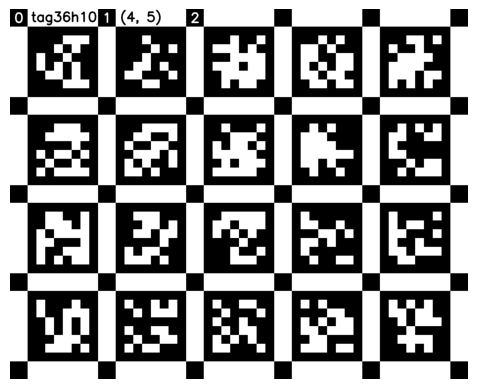

In [63]:
board = ApriltagBoard.create(4,5,"tag36h10", 0.02)
tgt = board.board

# filename = "apriltag_target.png"
# imageio.imwrite(filename, tgt)

plt.imshow(tgt, cmap="gray")
plt.axis("off");

Total tags found 20, tag ids:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


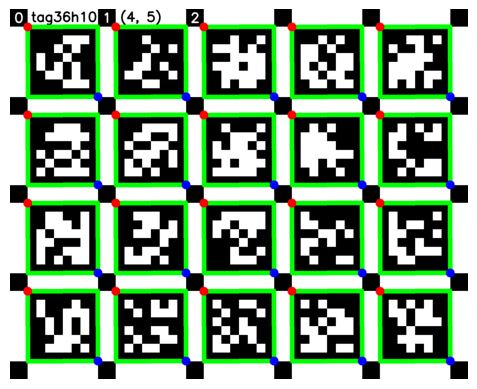

In [67]:
def find(img):
    # ok, img = cv2.threshold(img,150,255,cv2.THRESH_BINARY)
    # img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,0)
    
    corners, ids, rejectedImgPts = aruco.detectMarkers(
        img,
        aruco.Dictionary_get(aruco.DICT_APRILTAG_36h10), 
        parameters=aruco.DetectorParameters_create(),
    )
    
    # 36h10 is 8x8
    # min pix/bit sampling 5
    # need each side of tag to 8*5 = 40
    # min_pix = 40
    # for i,c in zip(ids, corners[0]):
    #     # print(c)
    #     dist = np.sqrt((c[0,0] - c[1,0])**2 + (c[0,1] - c[1,1])**2)
    #     if dist < min_pix:
    #         print(f"Bad image {i}: {c}")

    # turn the detections into a list of Tags and draw them on the image
    # tags = ApriltagMarker.tagArray(ids, corners)
    at = ApriltagMarker()
    img = at.draw(img, ids, corners, mark=False)

    ids = ids.flatten()
    ids = sorted(ids)
    print(f"Total tags found {len(ids)}, tag ids:")
    for i in ids:
        print(i, end=" ")
    print("")
    return img


img = find(tgt)
plt.imshow(img)
plt.axis("off");

In [5]:
path = Path("cal_imgs")
files = list(path.rglob("*.png"))
func = lambda f: int(f.stem) # 
files = sorted(files, key=func)

imgs = []
for f in files:
    f = str(f)
    imgs.append(cv2.imread(f, 0))
print(f"{len(imgs)} images found")

44 images found


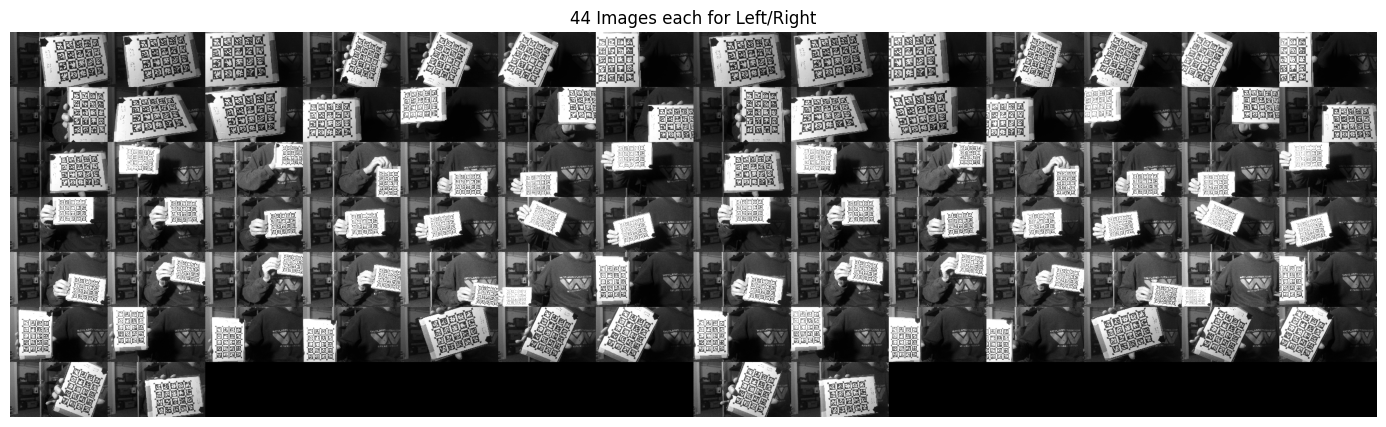

In [36]:
imgsL, imgsR = [], []
h,w = imgs[0].shape

for im in imgs:
    l = im[:, :w//2]
    r = im[:, w//2:]
    
    imgsL.append(l)
    imgsR.append(r)


l = mosaic(imgsL)
r = mosaic(imgsR)
plt.figure(figsize=(20,5))
plt.imshow(np.hstack((l,r)),cmap="gray")
plt.title(f"{len(imgsL)} Images each for Left/Right")
plt.axis("off");

Total tags found 19, tag ids:
0 1 2 3 4 5 6 7 8 9 10 12 13 14 15 16 17 18 19 
Total tags found 19, tag ids:
0 1 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


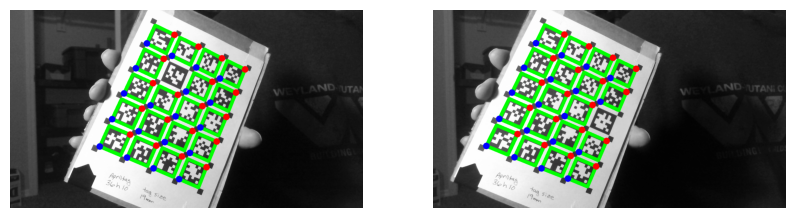

In [65]:
plt.figure(figsize=(10,5))
num = 4
plt.subplot(121); plt.imshow(find(imgsL[num]));plt.axis("off");
plt.subplot(122); plt.imshow(find(imgsR[num]));plt.axis("off");

## Calibrate Stereo Camera using Apriltags

In [64]:
objpts = board.objPoints
print(objpts[0])

# [[0.025 0.025 0.   ]
#  [0.025 0.005 0.   ]
#  [0.005 0.005 0.   ]
#  [0.005 0.025 0.   ]]

[[0.025 0.025 0.   ]
 [0.025 0.005 0.   ]
 [0.005 0.005 0.   ]
 [0.005 0.025 0.   ]]


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


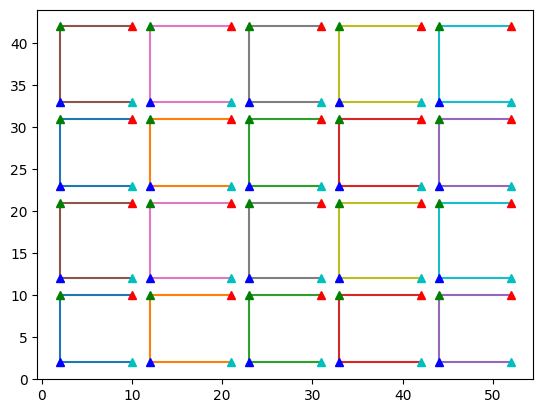

In [58]:
# this is upside down since
# (0,0) on an image is top left corner
# but here it is bottom left corner
#
# aruco pt order in image:
# 3     4
# +-----+
# |     |
# |     |
# +-----+
# 2     1
#
for k,v in objpts.items():
    v = 8/0.019 * v
    v = v.astype(int)
    plt.plot(v[:,1],v[:,0])
    plt.plot(v[0,1],v[0,0],"r^") # 1
    plt.plot(v[1,1],v[1,0],"g^") # 2
    plt.plot(v[2,1],v[2,0],"b^") # 3
    plt.plot(v[3,1],v[3,0],"c^") # 4

print(objpts.keys())

In [59]:
board = ApriltagBoard.create(4,5,"tag36h10", 0.02)
cc = MarkerCameraCalibration()

a,b,c = cc.findPoints(imgsL, board)
print(len(a), len(b), len(c))
print(a[0].shape,b[0].shape, c[0].shape)

44 44 44
(10,) (40, 2) (40, 3)


In [60]:
board = ApriltagBoard.create(4,5,"tag36h10", 0.02)

cal = ApriltagStereoCalibration()
ok, cameraModel = cal.calibrate(imgsL, imgsR, board)

In [61]:
cm = cameraModel # shorten variable name
sc = StereoCamera(
    cm["K1"],cm["d1"],
    cm["K2"],cm["d2"],
    cm["R"],cm["T"],
    cm["F"],
    cm["E"]
)

print(imgsL[0].shape)

h,w = imgsL[0].shape[:2]
f = max(h,w)*0.8  # focal length is a function of image size in pixels
K = np.array([
    [f,0,w//2],
    [0,f,h//2],
    [0,0,1]
])

print("Guess")
print(K)

print(sc)

sc.to_yaml("stereo_calibration.yml")

(720, 1280)
Guess
[[1024.    0.  640.]
 [   0. 1024.  360.]
 [   0.    0.    1.]]
Camera 1 --------------------------
  focalLength(x,y): 1044.5 1044.3 px 
  principlePoint(x,y): 621.1 369.7 px
  distortionCoeffs: [[ 0.108 -0.531  0.001  0.     0.627]]
Camera 2 --------------------------
  focalLength(x,y): 1043.0 1043.0 px 
  principlePoint(x,y): 626.5 368.9 px
  distortionCoeffs: [[ 0.108 -0.54   0.001 -0.003  0.681]]
Extrinsic Camera Parameters -------
  Translation between Left/Right Camera: [[-0.032]
 [-0.   ]
 [ 0.   ]]
  Rotation between Left/Right Camera:
    [[ 1.     0.001 -0.001]
     [-0.001  1.    -0.001]
     [ 0.001  0.001  1.   ]]
  Essential Matrix:
    [[-0.    -0.    -0.   ]
     [ 0.     0.     0.032]
     [ 0.    -0.032  0.   ]]
  Fundatmental Matrix:
    [[-0.    -0.    -0.009]
     [ 0.     0.     1.615]
     [ 0.011 -1.616  1.   ]]



Max points in this image set: 3520


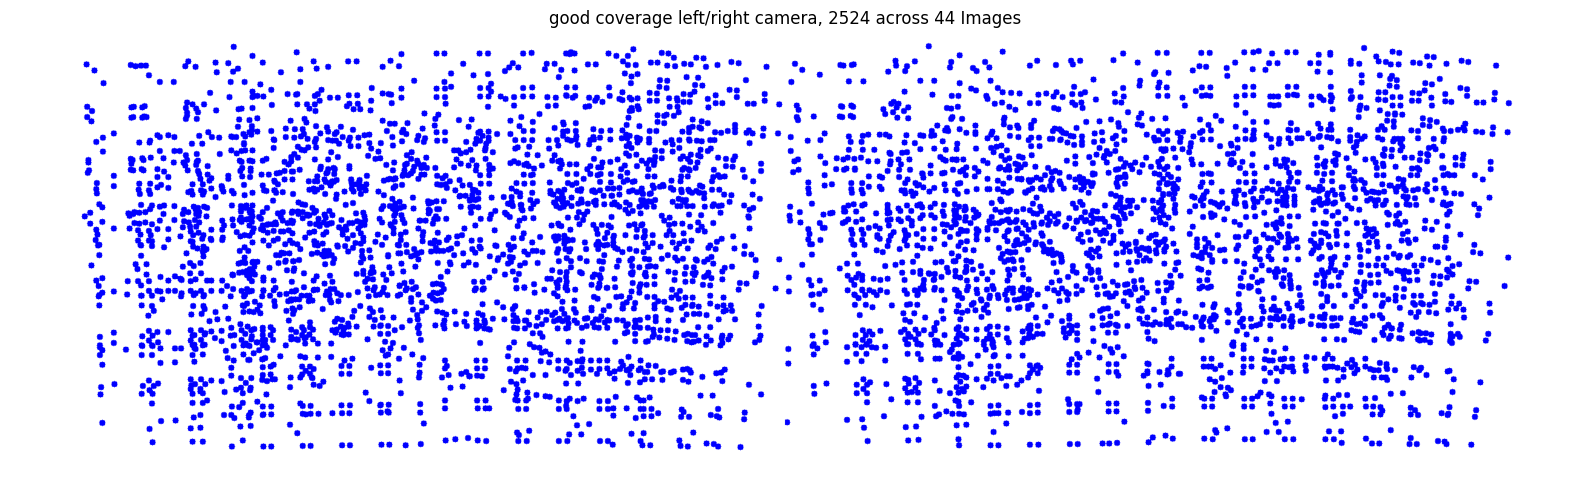

In [62]:
# draw image points mapped across camera focal plane
imgpoints_l = cameraModel["imgpointsL"]
imgpoints_r = cameraModel["imgpointsR"]

plt.figure(figsize=(20,10))
l, num = coverage(imgsL[0].shape[:2], np.vstack(imgpoints_l))
r, _ = coverage(imgsR[0].shape[:2], np.vstack(imgpoints_r))
plt.imshow(np.hstack((l,r)));
plt.title(f"good coverage left/right camera, {num} across {len(imgpoints_l)} Images")
plt.axis("off");

print(f"Max points in this image set: {4*5*4*44}")

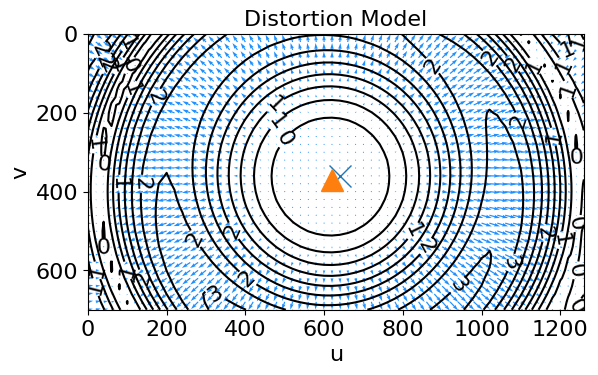

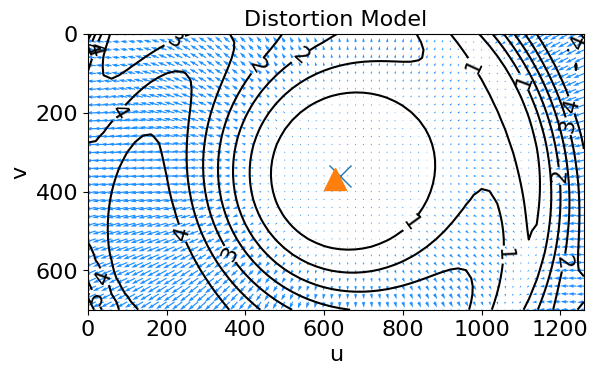

In [70]:
h,w = imgsL[0].shape[:2]

visualizeDistortion(sc.K1, sc.d1, h, w)
visualizeDistortion(sc.K2, sc.d2, h, w);

# Scratch Work

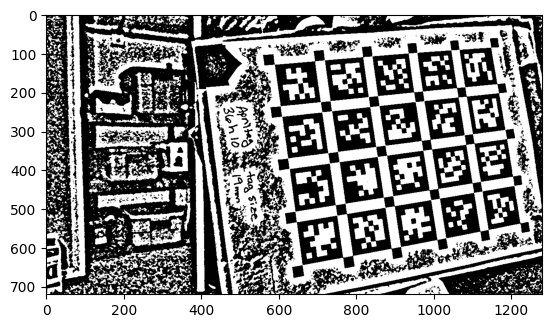

In [173]:
num = 0
# ok, img = cv2.threshold(imgsL[num],150,255,cv2.THRESH_BINARY)
img = cv2.adaptiveThreshold(imgsL[num],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,0)
plt.imshow(img,cmap="gray")

## calculating tag size

If interested in pixels/bit bit on images, could look at this to determine if you can read the tag.

However, if already have image corners, then already read tag ... is this useful?

In [127]:
a=2*np.array([
    [1,1],
    [0,1],
    [0,0],
    [1,0]
])

# a = np.rot90(a)

print(a)

[[2 2]
 [0 2]
 [0 0]
 [2 0]]


In [128]:
print(np.sum(np.subtract(a[0],a[1])**2))
print(np.sum(np.subtract(a[1],a[2])**2))
print(np.sum(np.subtract(a[2],a[3])**2))
print(np.sum(np.subtract(a[3],a[0])**2))

4
4
4
4


In [131]:
a = np.array([[ 502.,  332.],
        [1078.,  322.],
        [1068.,  904.],
        [ 513.,  905.]])
print(a)
print(np.sqrt(np.sum(np.subtract(a[0],a[1])**2)))
print(np.sqrt(np.sum(np.subtract(a[1],a[2])**2)))
print(np.sqrt(np.sum(np.subtract(a[2],a[3])**2)))
print(np.sqrt(np.sum(np.subtract(a[3],a[0])**2)))

[[ 502.  332.]
 [1078.  322.]
 [1068.  904.]
 [ 513.  905.]]
576.086799015565
582.0859043131005
555.0009009001697
573.1055749161754


In [40]:
np.array([1,2,3]).shape

(3,)